In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from datetime import datetime, date
from torchvision.transforms import transforms


In [47]:
import json
# Read configuration variables
with open("../config.json") as config_file:
    configuration = json.load(config_file)

In [4]:
# Hyperparameters
# LEARNING_RAtransformationsE = configuration["hyper_parameters"]["learning_rate"]
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# BAtransformationsCH_SIZE = configuration["hyper_parameters"]["batch_size"]
# NUM_EPOCHS = configuration["hyper_parameters"]["num_epochs"]
# NUM_WORKERS = configuration["hyper_parameters"]["num_workers"]
# IMAGE_HEIGHtransformations = configuration["input_image"]["image_height"]
# IMAGE_WIDTH = configuration["input_image"]["image_widths"]

# PIN_MEMORY = True # Flag to add dataloaders to cuda
# LOAD_MODEL = True
# MAX_NUM_SAMPLE_TRAIN = configuration["samples"]["max_num_sample_train"]
# MAX_NUM_SAMPLE_TEST = configuration["samples"]["max_num_sample_test"]
METADATA = f'../{configuration["experiment"]["metadata"]}'


In [8]:
# load dataset
data = pd.read_csv(METADATA, delimiter=";")
# Remove first unsued column 
data = data.iloc[:,1:]

In [9]:
data.head()
#data['Subject ID'].head()


,Subject ID,Session,Organism,Organism Part,Developmental Stage,# Lesions LH Cortical,# Lesions LH Subcortical,# Lesions RH Cortical,# Lesions RH Subcortical,# Lesions Other Location,Primary Stroke Hemisphere,Primary Stroke Location,Secondary Stroke Hemisphere,Secondary Stroke Location,Scanner Strength,Scanner Brand,Image Resolution,ATLAS 1.2
0,sub-r001s001,ses-1,Homo sapiens,Brain,Adult,0,1,1,2,0,Right,"Frontal Lobe, Parietal Lobe",Left,"Temporal Lobe, Putamen",3T,GE Signa Excite,1.0 x 1.0 x 1.0 mm,1
1,sub-r001s002,ses-1,Homo sapiens,Brain,Adult,0,1,1,0,0,Right,"Occipital Lobe, Temporal Lobe",Left,"Temporal Lobe, Putamen",3T,GE Signa Excite,1.0 x 1.0 x 1.0 mm,1
2,sub-r001s003,ses-1,Homo sapiens,Brain,Adult,0,1,0,1,0,Right,"Basal Ganglia, Caudate",Left,Frontal Lobe,3T,GE Signa Excite,1.0 x 1.0 x 1.0 mm,1
3,sub-r001s004,ses-1,Homo sapiens,Brain,Adult,1,0,0,0,1,Left,"Frontal Lobe, Parietal Lobe",Other,Cerebellum,3T,GE Signa Excite,1.0 x 1.0 x 1.0 mm,1
4,sub-r001s005,ses-1,Homo sapiens,Brain,Adult,0,1,0,0,0,Left,"Basal Ganglia, Caudate, Insula",NaN,NaN,3T,GE Signa Excite,1.0 x 1.0 x 1.0 mm,1


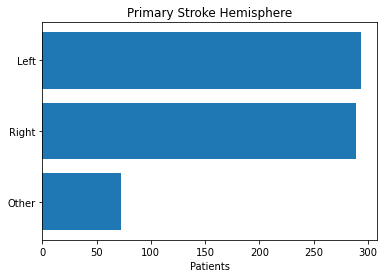

In [10]:

fig, ax = plt.subplots()
data.loc[:,"Primary Stroke Hemisphere"].value_counts()

# Example data
ax.barh(data.loc[:,"Primary Stroke Hemisphere"].value_counts().index,
        data.loc[:,"Primary Stroke Hemisphere"].value_counts(),
        align='center')
#ax.set_yticks(y_pos, labels=data['Primary Stroke Hemisphere'].unique)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Patients')
ax.set_title('Primary Stroke Hemisphere')
plt.show()

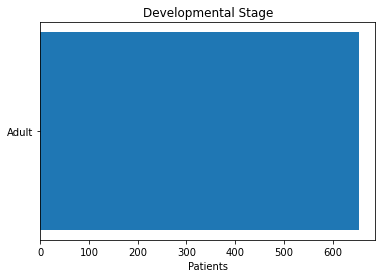

In [11]:
column = "Developmental Stage"
fig, ax = plt.subplots()
data.loc[:,column].value_counts()

# Example data
ax.barh(data.loc[:,column].value_counts().index,
        data.loc[:,column].value_counts(),
        align='center')
#ax.set_yticks(y_pos, labels=data['Primary Stroke Hemisphere'].unique)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Patients')
ax.set_title(column)
plt.show()

In [66]:
import napari
import nibabel as nib

viewer = napari.Viewer()

In [69]:
# Display the original image
original = "../dataset/train/images/sub-r001s001_ses-1_T1w.nii.gz"
mask="../dataset/train/masks/sub-r001s001_ses-1_space-orig_label-L_desc-T1lesion_mask.nii.gz"
prediction="../predictions/result_1_2022-04-26.nii"

test_load = nib.load(original)
#test_load = nib.load(original)
input_image = test_load.get_fdata() # last dimension is depth
viewer.add_image(np.transpose(input_image, axes=[2,0,1]), name="Original")
input_image = np.transpose(input_image, (0,1,2))



In [49]:
import os
from skimage import data, util, measure
from torchvision.transforms import Resize
# Train
test_images = f'../dataset/train/images/'
test_masks = f'../dataset/train/masks/'
dataset = "Train"
color = "red"

# Test
# test_images = f'../{configuration["folders_brain_stroke"]["test_img_dir"]}'
# test_masks = f'../{configuration["folders_brain_stroke"]["test_mask_dir"]}'
# dataset = "Testing"
# color = "blue"

#Validation
# test_images = f'../{configuration["folders_brain_stroke"]["val_img_dir"]}'
# test_masks = f'../{configuration["folders_brain_stroke"]["val_mask_dir"]}'
# dataset = "Validation"
# color = "green"

print(test_masks)
# count folders
total_files_patient = 0
centroids = []
areas = []
sequences = []
images_with_masks = 0
# Patients
for folder in os.listdir(test_masks):
    if os.path.isdir(f"{test_masks}{folder}"):
        total_files_patient += 1
        # Sequence of files
        sequence = 0
        for file in os.listdir(f"{test_masks}{folder}"):
            if ".png" in file:
                sequence += 1
                with Image.open(f"{test_masks}{folder}/{file}").convert("L") as img:
                    img = Resize(size=(224,224))(img)    
                    img_array = np.asarray(img)/255        
                    contours = measure.find_contours(img_array,0.6)
                    labels = measure.label(img_array, connectivity=1)
                    props = measure.regionprops(labels)
                    area = np.sum(img_array)        
                    [centroids.append(prop.centroid) for prop in props]
                    
                    if area > 0:
                        areas.append(area/img_array.size*100)
                        images_with_masks += 1
        sequences.append(sequence)
    # if total_files_patient == 2:
    #     break
print(f"====\nImages with masks: {images_with_masks}\n Patients: {total_files_patient}\n Avg Sequences per Patient: {np.mean(sequences)}\nMax Sequence: {np.max(sequences)}\n Min Sequence: {np.min(sequences)} ")


../dataset/train/masks/
====
Images with masks: 12189
 Patients: 308
 Avg Sequences per Patient: 221.89285714285714
Max Sequence: 512
 Min Sequence: 72 


In [ ]:
# from skimage import data, util, measure

# background = np.zeros((626, 965)) 
# train_masks = f'../dataset/train/masks/'
# centroids = []
# areas = []
# images_with_masks = 0
# for mask in os.listdir(train_masks):
#     with Image.open(f"{train_masks}{mask}").convert("L") as img:    
#         img_array = np.asarray(img)/255        
#         contours = measure.find_contours(img_array,0.6)
#         labels = measure.label(img_array, connectivity=1)
#         props = measure.regionprops(labels)
#         area = np.sum(img_array)        
#         [centroids.append(prop.centroid) for prop in props]
        
#         if area > 0:
#             areas.append(area/img_array.size*100)
#             images_with_masks += 1
            
# print(f"====\nImages with masks: {images_with_masks} ")

Strokes found: 21515


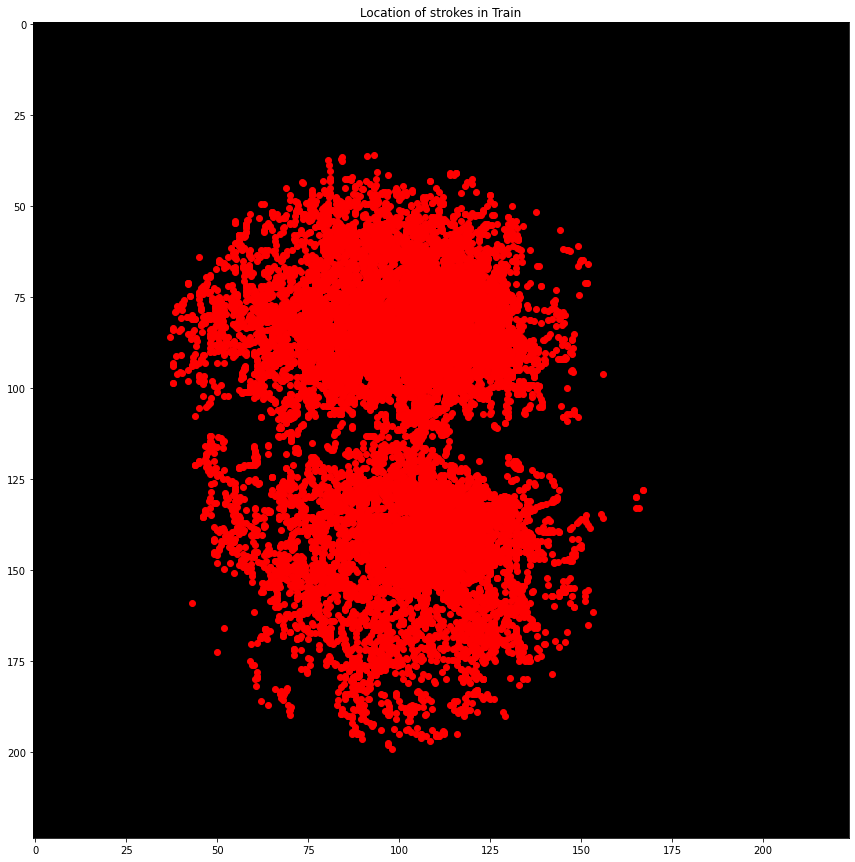

In [51]:
background = np.zeros((224, 224)) 
# Display the image and plot all contours found
print(f"Strokes found: {len(centroids)}")
fig, ax = plt.subplots( figsize=(15,15))
ax.imshow(background, cmap="gray")
[ax.plot(c[1],c[0], color=color, marker='o') for c in centroids]
plt.title(f"Location of strokes in {dataset}")
ax.axis('image')
plt.show()


In [114]:

# print(f"Strokes found: {len(centroids)}")
# fig, ax = plt.subplots( figsize=(15,15))
# ax.imshow(background, cmap="gray")
# [ax.plot(c[1],c[0], color='red', marker='o') for c in centroids]
# ax.axis('image')
# plt.show()
# plt.imshow(arr, cmap='viridis')
# plt.colorbar()
# plt.imshow(a, cmap='hot', interpolation='nearest')

tuple

In [11]:
#Concatenate  stroke location results
import cv2
print("Concatenating final results")

result_folder = "../dataProcessing/Stroke/ComparisonStrokeLocation.png"
training_img = "../dataProcessing/Stroke/TrainingStrokeLocation.png"
testing_img = "../dataProcessing/Stroke/TestingStrokeLocation.png"
validation_img = "../dataProcessing/Stroke/ValidationStrokeLocation.png"

imgs = []
imgs.append(cv2.imread(training_img))
imgs.append(cv2.imread(validation_img))
imgs.append(cv2.imread(testing_img))
# show the output image
cv2.imwrite(f'{result_folder}', cv2.hconcat(imgs))

Concatenating final results


True

In [52]:
#Concatenate  histogram images
import cv2
print("Concatenating final results")

result_folder = "../dataProcessing/Stroke/ComparisonAreaStrokes.png"
training_img = "../dataProcessing/Stroke/TrainStrokeAreaHistogram.png"
testing_img = "../dataProcessing/Stroke/TestingStrokeAreaHistogram.png"
validation_img = "../dataProcessing/Stroke/ValidationStrokeAreaHistogram.png"

imgs = []
imgs.append(cv2.imread(training_img))
imgs.append(cv2.imread(validation_img))
imgs.append(cv2.imread(testing_img))
# show the output image
cv2.imwrite(f'{result_folder}', cv2.hconcat(imgs))

Concatenating final results


True

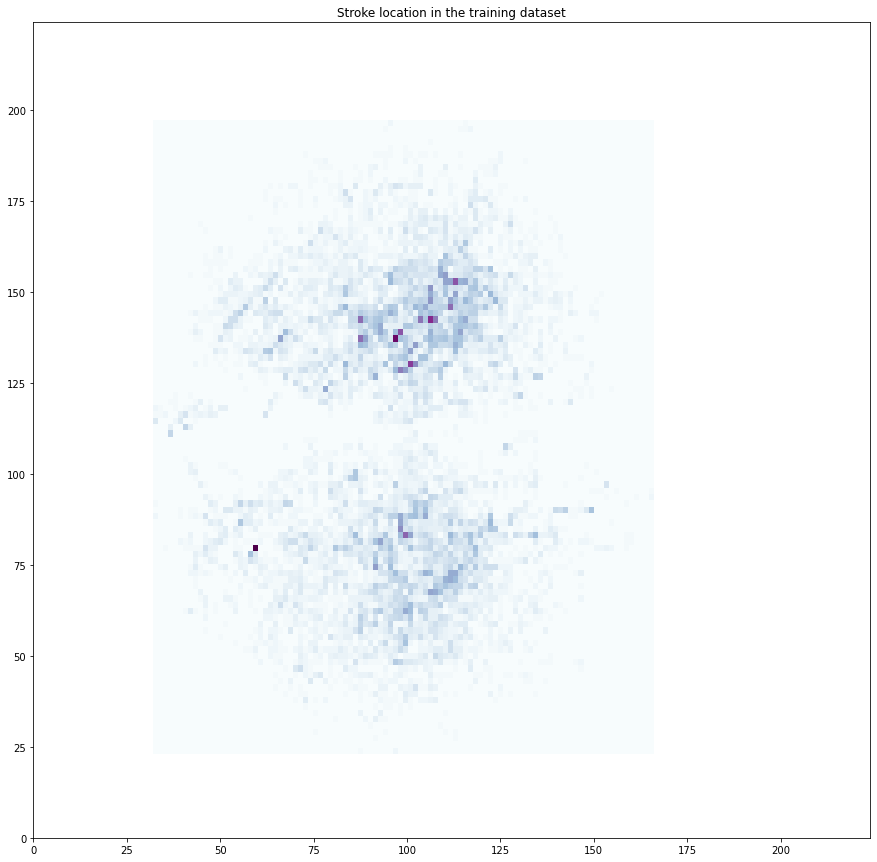

In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Define numbers of generated data points and bins per axis.
N_numbers = 100000
N_bins = 100

# set random seed 
np.random.seed(0)

# Generate 2D normally distributed numbers.
x = []
y = []
for c in centroids:
    x.append(c[1])
    y.append(c[0])
# Construct 2D histogram from data using the 'plasma' colormap
fig, ax = plt.subplots( figsize=(15,15))
plt.hist2d(x, y, bins=N_bins, cmap='BuPu')

# Plot a colorbar with label.
#cb = plt.colorbar()
#cb.set_label('Number of strokes')

# Add title and labels to plot.
plt.title('Stroke location in the training dataset')
plt.xlabel('')
plt.ylabel('')
plt.xlim([0, 224])
plt.ylim([0, 224])
# Show the plot. background = np.zeros((626, 965)) 
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

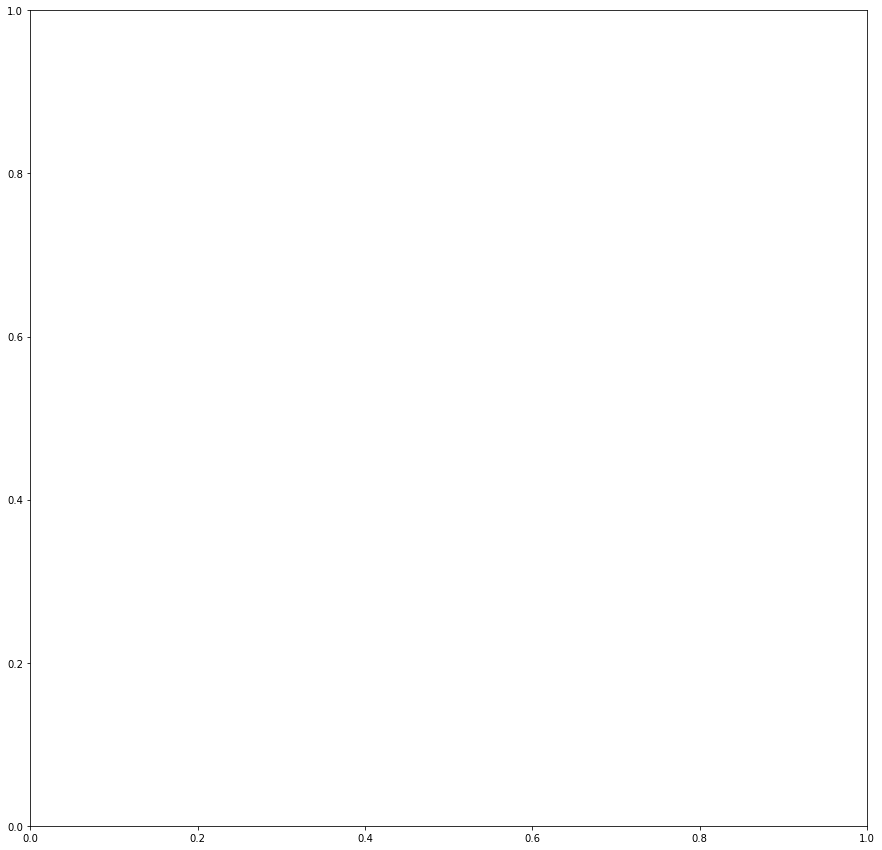

In [34]:

# Generate 2D normally distributed numbers.
x = []
y = []
z = range(0,20)
for c in centroids:
    x.append(c[1])
    y.append(c[0])
# Construct 2D histogram from data using the 'plasma' colormap
fig, ax = plt.subplots( figsize=(15,15))
#plt.hist2d(x, y, bins=N_bins, cmap='plasma')
ax.pcolor(x, y, None, cmap='RdBu', vmin=0, vmax=65)
ax.set_title('pcolor')
fig.colorbar(c, ax=ax)

# Add title and labels to plot.
plt.title('Stroke location in the training dataset')
plt.xlabel('')
plt.ylabel('')

# Show the plot.
plt.show()


Summary of areas:
Strokes found: 12189
Max: 10.83% 
Min: 0.00% 
Avg: 0.75%
Median: 0.23%


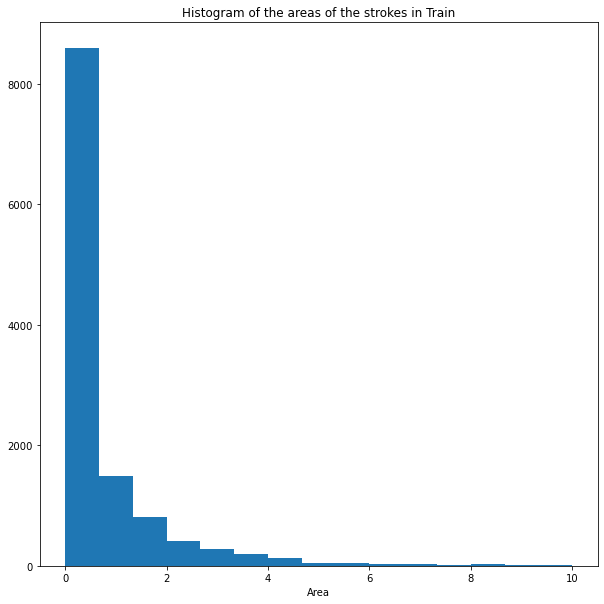

Train


In [50]:
#max_value = 1
folder_result = f"../dataProcessing/Stroke/{dataset}StrokeAreaHistogram.png"
print(f"Summary of areas:\nStrokes found: {len(areas)}\nMax: {max(areas):.2f}% \nMin: {min(areas):.2f}% \nAvg: {np.mean(areas):.2f}%\nMedian: {np.median(areas):.2f}%")
max_value = int(max(areas))
#print(areas[0:5])
fig, ax = plt.subplots( figsize=(10,10))
ax.hist(areas, range=(0,max_value), bins=15)
plt.title(f"Histogram of the areas of the strokes in {dataset}")
plt.xlabel("Area")
plt.savefig(folder_result, bbox_inches='tight')
plt.show()
print(dataset)

Summary of areas:
Strokes found: 8216
Max: 10.86% 
Min: 0.00% 
Avg: 1.62%
Median: 0.75%


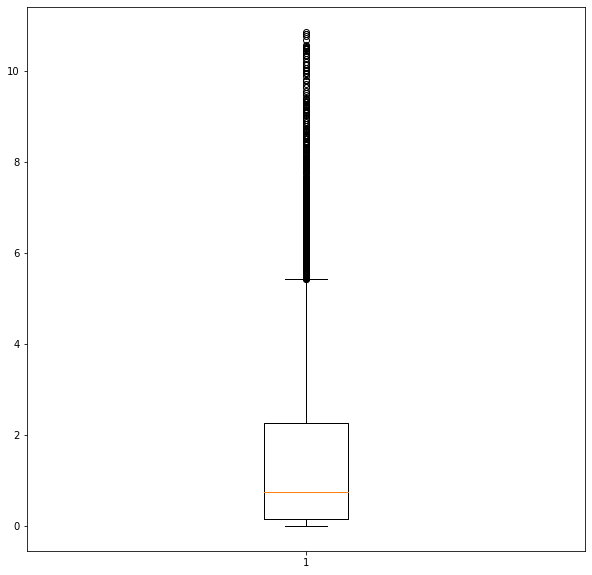

In [42]:
#max_value = 1
print(f"Summary of areas:\nStrokes found: {len(areas)}\nMax: {max(areas):.2f}% \nMin: {min(areas):.2f}% \nAvg: {np.mean(areas):.2f}%\nMedian: {np.median(areas):.2f}%")
max_value = int(max(areas))
#print(areas[0:5])
fig, ax = plt.subplots( figsize=(10,10))
ax.boxplot(areas)
plt.show()

10
10
10


ValueError: not enough values to unpack (expected 2, got 1)

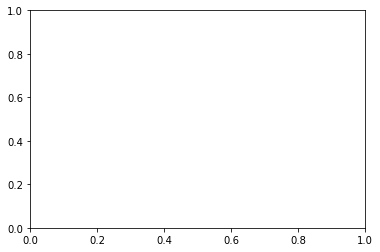

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# generate 2 2d grids for the x & y bounds
y = np.zeros(10)
x = np.zeros(10)

z = np.ones(10)

print(len(x))
print(len(y))
print(len(z))

fig, ax = plt.subplots()

c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=0, vmax=10)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [2]:
import seaborn as sns
ax = sns.heatmap(centroids)

NameError: name 'centroids' is not defined

In [1]:
import pandas as pd
import numpy as np

In [12]:
# Load files as dataframes
training = pd.read_csv("../dataProcessing/training_files.csv", sep=",")
training = training.loc[:,"Depth"]
#training.head()
validation = pd.read_csv("../dataProcessing/validation_files.csv", sep=",")
validation = validation.loc[:,"Depth"]
testing = pd.read_csv("../dataProcessing/test_files.csv", sep=",")
testing = testing.loc[:,"Depth"]
testing.head()

0    256
1    256
2    256
3    256
4    256
Name: Depth, dtype: int64

In [13]:
print(training.head())
print(testing.head())
print(validation.head())


0    181
1    155
2    197
3    197
4    195
Name: Depth, dtype: int64
0    256
1    256
2    256
3    256
4    256
Name: Depth, dtype: int64
0    168
1    196
2    190
3    153
4    185
Name: Depth, dtype: int64


In [14]:
import matplotlib.pyplot as plt

result = pd.concat([training,testing, validation])
len(result)
result.head()



0    181
1    155
2    197
3    197
4    195
Name: Depth, dtype: int64

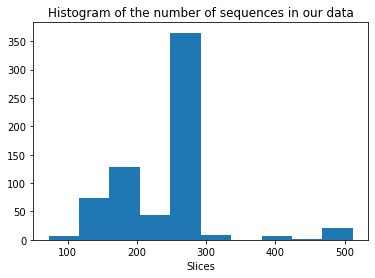

In [36]:
result_img = "../dataProcessing/Stroke/HistogramOfSlices.png"

# fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
# ax.hist(result)
# ax.set_title("Histogram of the number of sequences in our data")
# ax.set_xlabel("a")
# fig.savefig(result_img)   # save the figure to file
# plt.close(fig)    # close the figure window

plt.hist(result)
plt.title("Histogram of the number of sequences in our data")
plt.xlabel("Slices")
plt.savefig(result_img, bbox_inches='tight')
plt.show()
plt.close()

In [116]:
import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision
import torch

img_c = Image.open("../dataset/train/images/sub-r001s001_ses/0114.png")
img_d = Image.open("../dataset/train/masks/sub-r001s001_ses_mask/0084.png")
# Original image
#img_c.show()
#img_d.show()
class CustomRandomChoice(torch.nn.Module):
    def __init__(self):
       super().__init__()       


    def __call__(self, img, mask):        
        
         #t = random.choice(self.transforms)
        image = transforms.Grayscale()(img)
        seg = transforms.Grayscale()(mask)

        #t = random.choice(self.transforms)
        # image = [t(img) for t in self.transforms][-1]
        # seg = [t(mask) for t in self.transforms][-1]

        # Adjusting gamma
        image = TF.adjust_gamma(img=image, gamma=1)
        image = TF.adjust_contrast(image,2)

        # Rotating image
        angle_ = random.randint(0, 180)    
        image = TF.rotate(image, angle=angle_)
        seg = TF.rotate(seg, angle=angle_)

        #Random crop
        # if type(image) == Image.Image: 
        #     w, h = image.size
        # else:
        #     w, h = image.shape[1], image.shape[2]
        # x1 = random.randint(0, w)
        # y1 = random.randint(0, h)
        # image = TF.crop(image,x1,y1,x1 + IMAGE_WIDTH,y1 + IMAGE_HEIGHT)
        # seg = TF.crop(seg,x1,y1,x1 + IMAGE_WIDTH,y1 + IMAGE_HEIGHT)

        
        # Gaussian blur
        random_sigma =  random.randint(1, 5)
        #print(random_sigma)     
        blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, random_sigma))
        image = blurrer(image)

        # Resize
        image = transforms.Resize((224,224))(image)
        seg = transforms.Resize((224,224))(seg)

        # To tensor
        image =  transforms.ToTensor()(image)
        seg =  transforms.ToTensor()(seg)
        
        return image, seg

class CustomOriginalImages(torch.nn.Module):
    def __init__(self):
       super().__init__()       


    def __call__(self, img, mask):        
        
        #t = random.choice(self.transforms)
        image = transforms.Grayscale()(img)
        if mask is not None:
            seg = transforms.Grayscale()(mask)
        
        # Adjusting gamma
        image = TF.adjust_gamma(img=image, gamma=1)
        image = TF.adjust_contrast(image,2)               
            
        # Resize
        image = transforms.Resize((224,224))(image)
        if mask is not None:
            seg = transforms.Resize((224,224))(seg)

        # To tensor
        image =  transforms.ToTensor()(image)
        if mask is not None:
            seg =  transforms.ToTensor()(seg)
            
        return image, (seg if mask is not None else None)

transform_original = CustomOriginalImages()
transform = CustomRandomChoice()
res = transform_original(img_c, img_d)
o = transform(img_c, img_d)
#display(res[0]) # both img_c and img_d will
#display(res[1]) # both img_c and img_d will
result = torch.cat((res[0].unsqueeze(dim=0), res[1].unsqueeze(dim=0), o[0].unsqueeze(dim=0), o[1].unsqueeze(dim=0)), dim=0)
print(result.shape)
grid = torchvision.utils.make_grid(result, nrow=4, padding=100)
torchvision.utils.save_image(grid, '../dataProcessing/Stroke/dataAugmentationInput.png')  

torch.Size([4, 1, 224, 224])


In [104]:
#torch.max(res[0])
res[0][0,100:110,100:110]


tensor([[0.0745, 0.0706, 0.0588, 0.0667, 0.0549, 0.0667, 0.1137, 0.2000, 0.2196,
         0.2392],
        [0.0745, 0.0706, 0.0667, 0.0627, 0.0510, 0.0471, 0.0745, 0.1294, 0.1294,
         0.1373],
        [0.0510, 0.0627, 0.0784, 0.0627, 0.0706, 0.0706, 0.0784, 0.0784, 0.0706,
         0.0784],
        [0.0392, 0.0471, 0.0784, 0.0784, 0.1020, 0.1020, 0.1098, 0.0941, 0.0941,
         0.1137],
        [0.0627, 0.0667, 0.0824, 0.0941, 0.0902, 0.0980, 0.1137, 0.1059, 0.1020,
         0.1059],
        [0.0784, 0.0902, 0.0902, 0.1020, 0.0706, 0.0980, 0.1294, 0.1255, 0.1098,
         0.1020],
        [0.0745, 0.0980, 0.0941, 0.0980, 0.0745, 0.1020, 0.1294, 0.1176, 0.1059,
         0.1059],
        [0.0745, 0.0980, 0.1020, 0.0941, 0.0902, 0.1059, 0.1098, 0.1020, 0.0941,
         0.1020],
        [0.0824, 0.0902, 0.1020, 0.0941, 0.0863, 0.0863, 0.0941, 0.1098, 0.0863,
         0.0824],
        [0.0745, 0.0784, 0.0745, 0.0824, 0.0824, 0.0902, 0.1137, 0.1176, 0.0784,
         0.0745]])

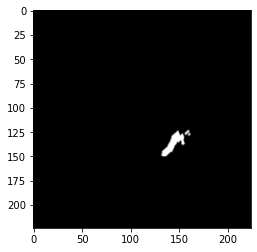

In [64]:
plt.imshow(res[1][0,:,:], cmap="gray")
plt.savefig("../dataProcessing/Stroke/dataAugmentationMask.png")

In [ ]:
# Implement same transformation but from the nifti file directly

import random
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch

img_c = Image.open("../dataset/train/images/sub-r001s001_ses/0114.png")
img_d = Image.open("../dataset/train/masks/sub-r001s001_ses_mask/0084.png")

class CustomRandomChoice(torch.nn.Module):
    def __init__(self):
       super().__init__()       


    def __call__(self, img, mask):        
        
        image = transforms.Grayscale()(img)
        seg = transforms.Grayscale()(mask)

        #t = random.choice(self.transforms)
        # image = [t(img) for t in self.transforms][-1]
        # seg = [t(mask) for t in self.transforms][-1]

        # Adjusting gamma
        image = TF.adjust_gamma(img=image, gamma=1)
        image = TF.adjust_contrast(image,2)

        # Rotating image
        angle_ = random.randint(0, 180)        
        image = TF.rotate(image, angle=angle_)
        seg = TF.rotate(seg, angle=angle_)

        #Random crop
        # if type(image) == Image.Image: 
        #     w, h = image.size
        # else:
        #     w, h = image.shape[1], image.shape[2]
        # x1 = random.randint(0, w)
        # y1 = random.randint(0, h)
        # image = TF.crop(image,x1,y1,x1 + 224,y1 + 224)
        # seg = TF.crop(seg,x1,y1,x1 + 224,y1 + 224)

        # Gaussian blur
        random_sigma =  random.randint(1, 5)        
        blurrer = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, random_sigma))
        image = blurrer(image)

        #image = T.CenterCrop(size=(224,224))(image)
        #seg = T.CenterCrop(size=(224,224))(seg)

        # Resize
        image = transforms.Resize((224,224))(image)
        seg = transforms.Resize((224,224))(seg)

        # To tensor
        image =  transforms.ToTensor()(image)
        seg =  transforms.ToTensor()(seg)
        return image, seg


transform = CustomRandomChoice()
res = transform(img_c, img_d)
display(res[0]) # both img_c and img_d will
display(res[1]) # both img_c and img_d will
#display(transform(img_d)) # have the same transform